In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='arial') 
from fish.image.zds import ZDS
import flika as flk
flk.start_flika()
from flika.window import Window as flw
from skimage.transform import downscale_local_mean
from functools import partial
from skimage.transform import rotate

Starting flika
Starting flika inside IPython


## Raw imaging example

In [ ]:
base_dir = '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170113/fish4/20170113_4_2_cy14_7dpf_more_trial_20170113_183025/raw/'
dset = ZDS(base_dir)
dset

In [ ]:
rotator = partial(rotate, angle=-4, mode='reflect', preserve_range=True)
sample = dset.data[0].compute()
sample_ds = downscale_local_mean(sample, (1,2,2))
sample_r = np.array([rotator(z) for z in sample_ds])[:,10:-10].transpose(0,2,1)
sample_r = np.vstack([sample_r] * 10)

In [ ]:
plt.imshow(sample_r.max(0).clip(100,150))

In [ ]:
fps = dset.shape[1] * dset.metadata['volume_rate']
#from fish.util.plot import nparray_to_video
fname = '/groups/ahrens/ahrenslab/davis/pres/light_sheet_imaging_realtime_example.mp4'
nparray_to_video(fname, sample_r.clip(100,200), fps=fps)

## Make a movie of some neuronal activity

In [4]:
%matplotlib inline
import shutil
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import cm
from scipy.interpolate import interp1d
import numpy as np
from skimage.io import imread
from fish.image.zds import ZDS
from fish.ephys.ephys import load
from fish.util.distributed import get_jobqueue_cluster
import dask.array as da
from dask.distributed import Client
from dask.array import coarsen
from dask.delayed import delayed
from functools import partial
from dask import threaded
from h5py import File
import flika as flk
import time
import attr
flk.start_flika()
from flika.window import Window as flw
from skimage.transform import downscale_local_mean
from scipy.ndimage.filters import median_filter

from skimage.exposure import rescale_intensity as rescale
from scipy.ndimage.filters import gaussian_filter
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

def rearrange(im):
    mp = im.shape[1]//2
    hemi = np.concatenate([im[:,:mp], im[:,mp:]], axis=2)
    padded = np.pad(hemi, ((0,0), (29,29), (29,29), (0,0)), mode='constant')
    mont = montage(padded, rgb=True)
    return mont

def montage(vol, rgb=False):
    if rgb:
        if vol.ndim == 4:
            return vol.reshape(vol.shape[0] * vol.shape[1], vol.shape[2], vol.shape[3])
        elif vol.ndim == 5:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3], vol.shape[4])
    else:
        if vol.ndim == 4:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3])
        elif vol.ndim == 5:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3], vol.shape[4])

Starting flika
flika menubar already initialized.
Starting flika inside IPython


In [6]:
base_dir = '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/'
ephys = File(base_dir + 'ephys/data.mat')['data']
gain_signal = np.squeeze(File(base_dir + 'ephys/rawdata.mat')['rawdata/stimGain'][:])
swims = np.squeeze(ephys['fltCh1'][:] + ephys['fltCh2'][:])
cam = np.squeeze(ephys['frame'][:]) - 1
frame = np.where(np.diff(cam).clip(0,None) == 1)[0]
shifts = -np.load(base_dir + 'regparams_affine.npy')[:,:-1,-1]
shifts = median_filter(shifts, size=(300,1))
dset = ZDS(base_dir + 'raw/')
exp_name = dset.metadata['data_header']
planes = np.arange(5, dset.shape[1]-3).astype('int')
zstep = int(np.diff(planes[:2]))
fs_im = dset.metadata['volume_rate']
print(planes)

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]


In [7]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

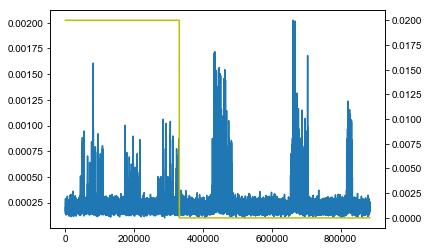

In [8]:
roi = (slice(292, 525), slice(planes[0], planes[-1], zstep), slice(None), slice(None))
plr = slice(np.where(cam == roi[0].start)[0][0], np.where(cam==roi[0].stop)[0][0])
plt.plot(swims[plr])
plt.twinx().plot(gain_signal[plr], color='y')

In [9]:
%%time
data = dset.data[roi]
data_tx = data.map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data_tx.map_blocks(medfilt)

ds_xy = 4
data_ds = coarsen(np.mean, data_filt, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 1, 'auto','auto'))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

ref_range = slice(0, 10)
ref = data_ds[ref_range].mean(0).compute(scheduler='threads')
out_path = f'/groups/ahrens/ahrenslab/davis/pres/{exp_name}_t{roi[0].start}t{roi[0].stop}_sfn.npy'

CPU times: user 10min 26s, sys: 14.7 s, total: 10min 40s
Wall time: 1min 19s


In [32]:
from dask_jobqueue import LSFCluster
cluster = LSFCluster(queue='normal',
                     project='bennettd',
                     walltime='00:30',
                     cores=1,
                     local_directory='/scratch/bennettd/',
                     memory='16GB')
cluster.adapt()

In [33]:
client = Client(cluster)
client

Client Scheduler: tcp://10.36.111.11:46622 Dashboard: http://10.36.111.11:38905/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [ ]:
%%time
#cluster.adapt()
result_dff = data_dff.compute()
#cluster.stop_workers(cluster.workers)
#cluster.cleanup_closed_workers()

In [51]:
result_dff.shape

(233, 20, 512, 512)

In [55]:
flw(result_dff.max(1))

In [ ]:
np.save(out_path, result_dff)

In [10]:
result_dff = np.load(out_path)
# crop the image to remove dff artifacts induced by motion correction
crop = (slice(None), slice(None), slice(None), slice(10, -10))
cropped=result_dff[crop]

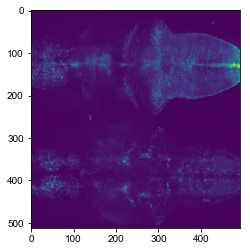

In [11]:
plt.imshow(cropped.max((0,1)))

In [12]:
gammas = [.5,1]
bg = (255 * (cm.gray(rescale(ref[crop[-3], crop[-2], crop[-1]],in_range=(102, 250), out_range=(0,.5)) ** gammas[0])[:,:,:,:-1])).astype('int')

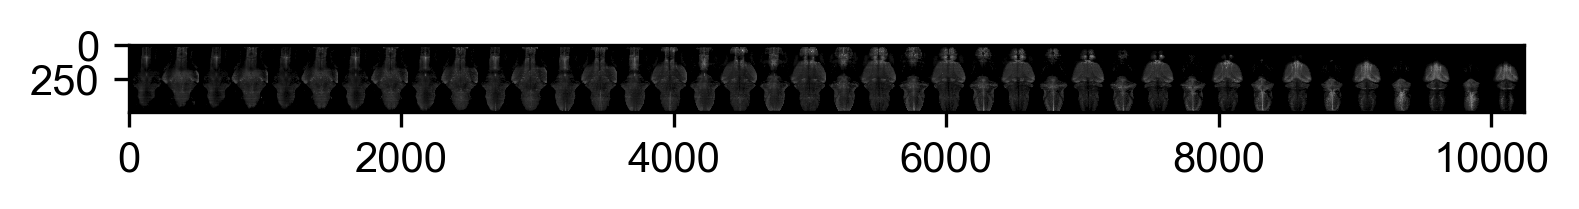

In [13]:
fig, axs = plt.subplots(dpi=300)
plt.imshow(montage(bg, rgb=True).transpose(1,0,2))

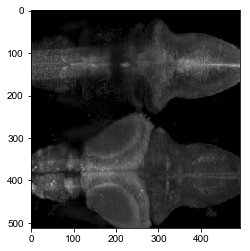

In [14]:
plt.imshow(bg.max(0))

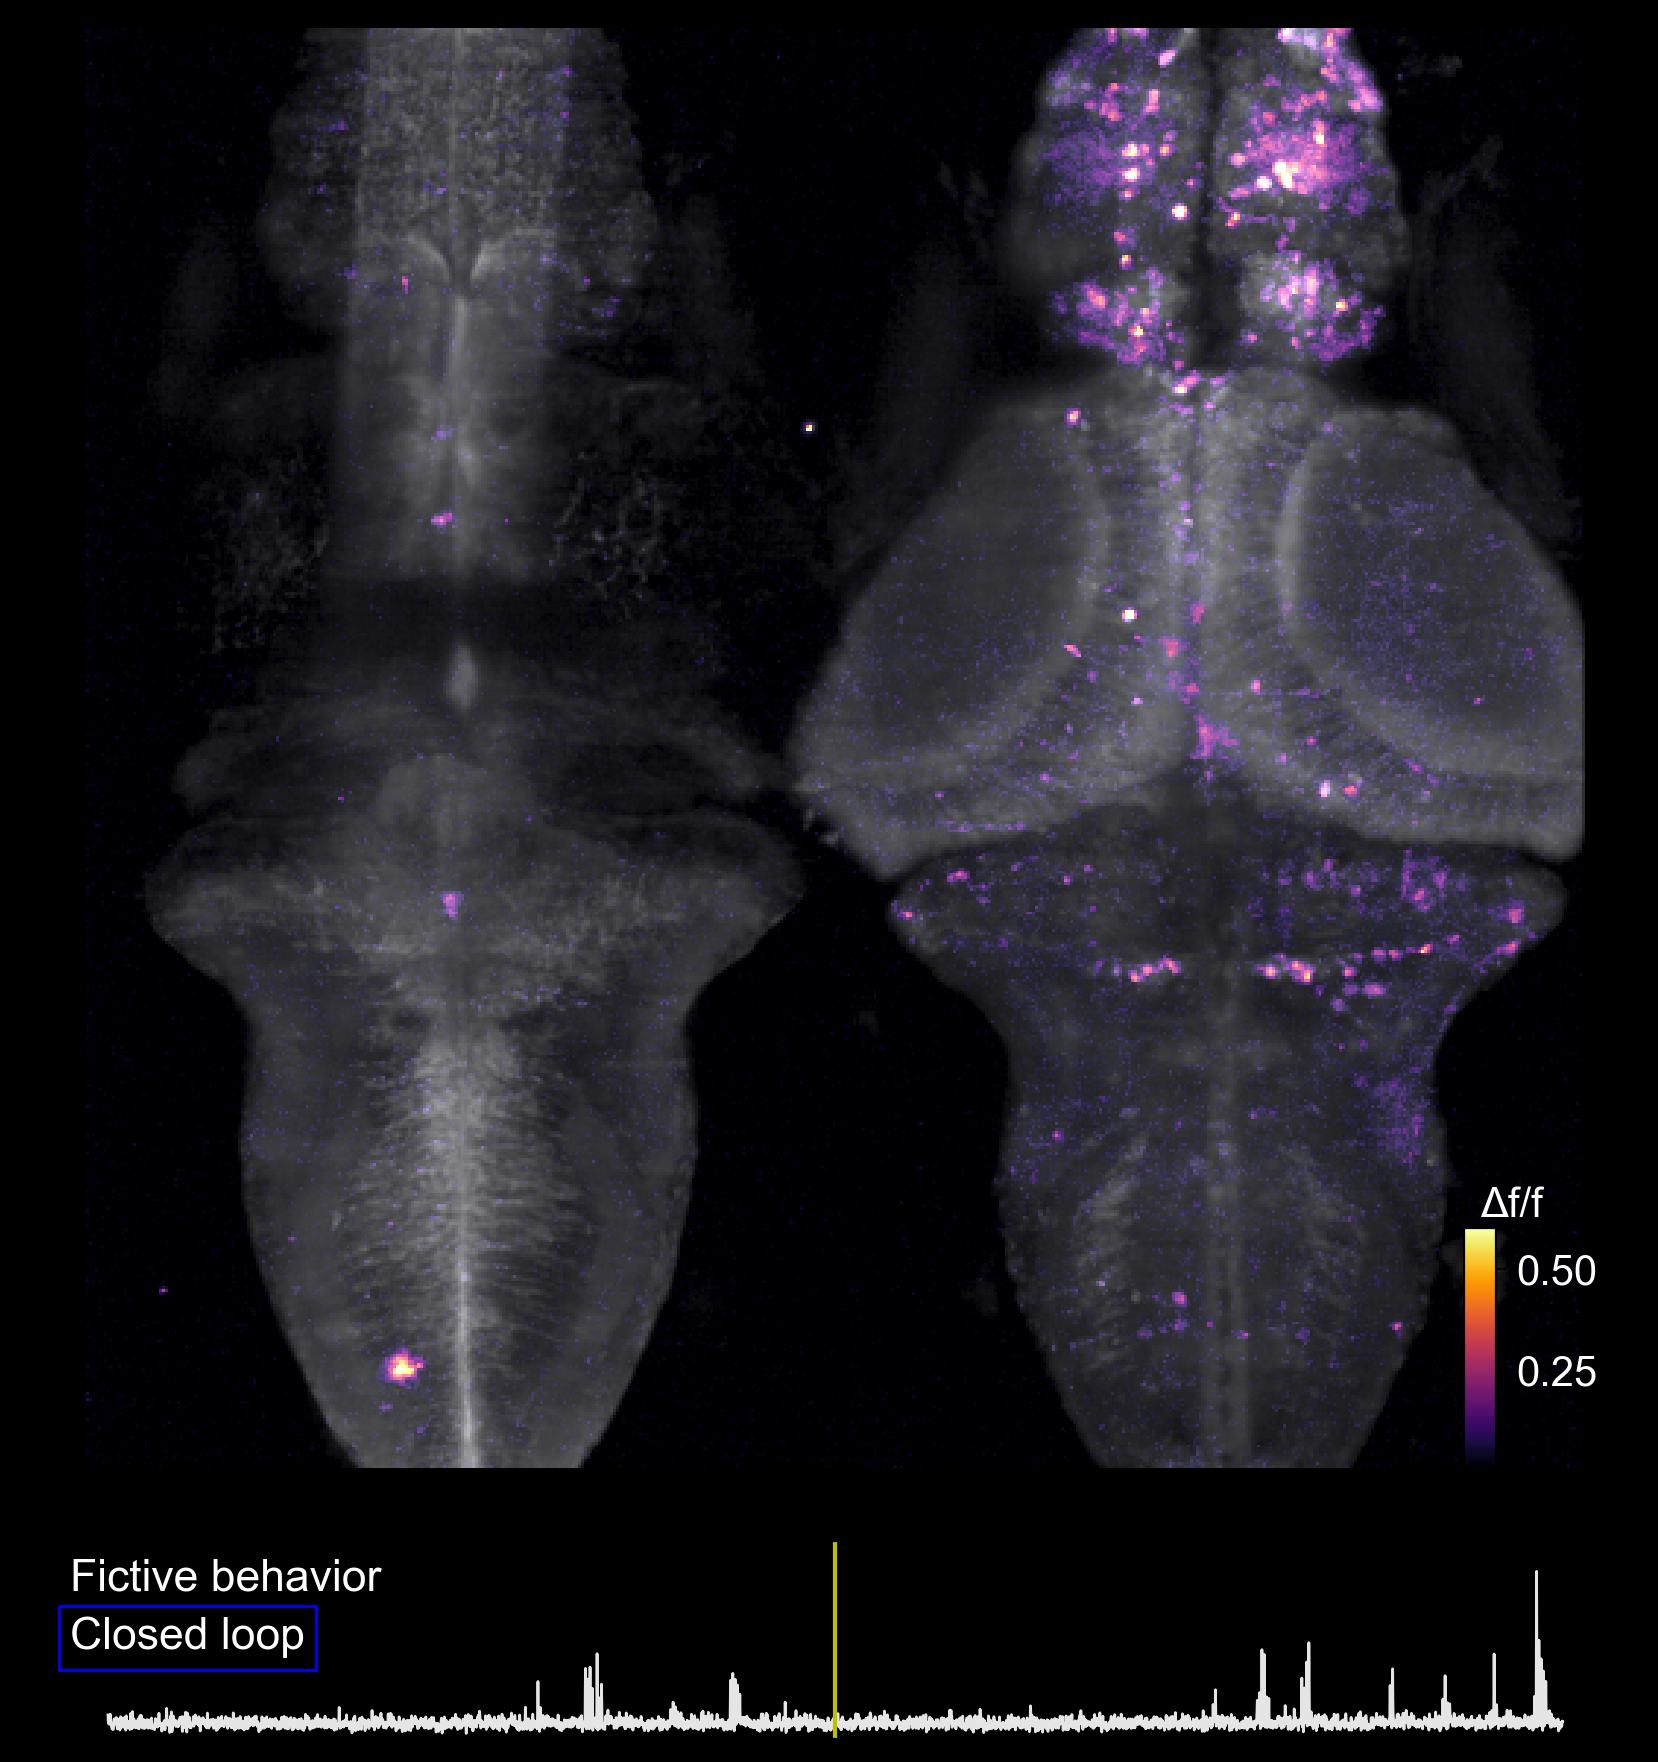

In [34]:
im_interp = interp1d(np.arange(cropped.shape[0]), cropped, axis=0)
frame_interp = interp1d(np.arange(frame.shape[0]), frame)
sample = bg.max(0).transpose(1,0,2)
fs_ep = 6000
flash_dur = fs_ep * 10
title_dur = 4
data_dur = 40
ind = 0
fps = 30
data_playback_scale = (cropped.shape[0] / fs_im) / data_dur

fd_big = {'fontsize' : 16, 'color' : (1, 1, 1)}
fd_small = {'fontsize' : 12, 'color' : (1, 1, 1)}
im_label_x = -105
gain_conds = ('Closed loop', 'Open loop')
gain_colors = ('b','y')
ep_label = 'Fictive behavior'

gammas = [.5,1]
bg = (255 * (cm.gray(rescale(ref[crop[-3], crop[-2], crop[-1]],in_range=(102, 250), out_range=(0,.5)) ** gammas[0]))).astype('int')

dff_range = (.01,.6)
ep_window = np.arange(-14 * fs_ep, 14 * fs_ep)

#zlabel_x = np.linspace(0, sample.shape[1] - bg.shape[1] //2, bg.shape[0]).astype('int')
#zlabel_y = np.array([0, sample.shape[0]//2]) + 70
#zlabels = [z.astype('str') + ' µm' for z in np.arange(dset.shape[1])[roi[1]] * zstep]
im_ar = bg.shape[1] / bg.shape[2]

figsize = (16/2, 9)
fig = plt.figure(dpi=200, figsize=figsize, facecolor='k')
#gsp = gs.GridSpec(10,10)
#ax_im = fig.add_subplot(gsp[:-1,:])

ax_im = fig.add_axes([0,.15,1,.8])
ax_im.axis('off')
#ax_im = fig.add_axes([0,.11,1,.89], yticks=[], xticks=[])


ax_im.imshow(np.random.randn(*sample.shape[:-1]), cmap='inferno', clim=dff_range)
ax_im_pos = ax_im.get_position()
ax_im.axis('off')

ax_cbar = fig.add_axes((ax_im_pos.xmax - .075, ax_im_pos.ymin, .02, ax_im_pos.height/6))
cbar = plt.colorbar(ax_im.images[0], cax = ax_cbar)
ax_cbar.text(.5, 1.05, '\u0394f/f', transform=ax_cbar.transAxes, fontdict={'fontsize' : 15, 'color' : (1, 1, 1)})
ax_cbar.set_facecolor('k')
ax_cbar.tick_params(labelcolor='w', labelsize=15)
dff_range = (.05, .6)
ax_ep = fig.add_axes([0,0,1,.11], xticks=[], yticks=[])
ax_ep.set_facecolor('k')
fig.subplots_adjust(hspace=0, wspace=0)

timing_label = dict(x = .022, y = .2, s=f'{data_playback_scale:.1f}X playback speed',transform=ax_ep.transAxes, fontdict=dict(color='w', size=8))
#ax_ep.text(**timing_label)
ax_ep.set_ylim(swims.min(), swims.max() / 3)
t_s_label = ax_ep.text(.022, .75, ep_label.format(0), transform=ax_ep.transAxes, fontdict=fd_big)
t_ep = np.where(cam == ind + roi[0].start)[0][0]

ep_plr = ep_plr = t_ep + ep_window    
ax_ep.plot(ep_window, swims[ep_plr], color='w', linewidth=1, alpha=.9)
ax_ep.axvline(0, color='y')

cond_label = ax_ep.text(.022, 
                        .45, 
                        gain_conds[(gain_signal[t_ep] == 0.0).astype('int')], 
                        transform=ax_ep.transAxes, 
                        fontdict=fd_big, 
                        bbox=dict(edgecolor=gain_colors[(gain_signal[t_ep] == 0.0).astype('int')], facecolor='k'))

def drawf(t_):    
    global ind
    
    if t_ == 0.0:
        ind = 0
    
    # time in seconds
    t_s = ind / fs_im
    
    # fractional time index  
    ind_s = t_ * (cropped.shape[0] - 1) / data_dur
    im = im_interp(ind_s)
                    
    composite = bg + rescale(cm.inferno(rescale(im, in_range=dff_range)), out_range='uint8').astype('uint8')
    mont = composite.max(0).transpose(1,0,2)
    #mont = composite.reshape((bg.shape[0] * bg.shape[1], bg.shape[2], bg.shape[3])).transpose(1,0,2)
    
    try:
        ax_im.images[0].set_data(mont)                
    except IndexError:
        ax_im.imshow(mont)                
            
    #t_ep = np.where(cam == ind + roi[0].start)[0][0]        
    t_ep = np.round(frame_interp(roi[0].start + ind_s)).astype('int')
    # make the bounding box blink at 1 fps for ~3s after open loop starts
    gain_switched = (gain_signal[t_ep] > 0.0) and (gain_signal[t_ep + flash_dur] == 0.0)    
    g_ind = (gain_signal[t_ep] == 0.0).astype('int')
    
    ep_plr = t_ep + ep_window    
    ax_ep.lines[0].set_data(ep_window, swims[ep_plr])  
    t_s_label.set_text(ep_label.format(t_s))

    cond_box_label_color = gain_colors[g_ind]
    if gain_switched:
        cond_box_label_color=gain_colors[ind // 5 % 2]    
    cond_label.set_text(gain_conds[g_ind])
    cond_label.set_bbox(dict(edgecolor=cond_box_label_color, facecolor='k'))
    
    ind += 1
    return mplfig_to_npimage(fig)

data_clip = VideoClip(drawf, duration=data_dur)

In [38]:
codec = 'h264'
vid_fname = f'/groups/ahrens/ahrenslab/davis/pres/{exp_name}_t{roi[0].start}t{roi[0].stop}_f360.mp4'
ind = 0
data_clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'], bitrate="10000k")

t:   0%|          | 0/1200 [00:00<?, ?it/s, now=None]

Moviepy - Building video /groups/ahrens/ahrenslab/davis/pres/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t292t525_f360.mp4.
Moviepy - Writing video /groups/ahrens/ahrenslab/davis/pres/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t292t525_f360.mp4



Moviepy - Done !
Moviepy - video ready /groups/ahrens/ahrenslab/davis/pres/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t292t525_f360.mp4


In [36]:
shutil.copy(vid_fname, 'test_glia_neuron.mp4')

'test_glia_neuron.mp4'

In [37]:
from IPython.display import HTML
HTML(f"""
<video width="800" height="800" controls>
  <source src="test_glia_neuron.mp4" type="video/mp4">
</video>
""")

## Make a movie of some glial activity

In [ ]:
base_dir = '/nrs/ahrens/davis/data/spim/raw/20160608/6dpf_cy171xcy221_f1_omr_1_20160608_170933/'
dset = ZDS(base_dir)
shifts = -np.load(base_dir.replace('raw','proc') + 'reg/regparams_affine.npy')[:,:-1,-1]

In [ ]:
sample = dset.data[0].compute(scheduler='threads')

In [ ]:
fs_im = dset.metadata['volume_rate'] 

def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

In [ ]:
roi= (slice(3000,None), slice(None), slice(1124, None), slice(52,None))
plt.imshow(sample[roi[1:]].max(0))

In [ ]:
from fish.util.distributed import get_cluster
from distributed import Client
cluster = get_cluster()
cluster.adapt()
client = Client(cluster)
client

In [ ]:
fps = 24
playback_speed = fps / dset.metadata['volume_rate']
playback_speed

In [ ]:
%%time
data = dset.data[roi]
data_tx = data.map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data_tx.map_blocks(medfilt)

ds_xy = 4
data_ds = coarsen(np.mean, data_filt, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 1, 'auto','auto'))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

ref_range = slice(0, 10)
ref = data_ds[ref_range].mean(0).compute(scheduler='threads')
out_path = f'/groups/ahrens/ahrenslab/davis/pres/{dset.exp_name}_t{roi[0].start}t{roi[0].stop}_sfn.npy'

In [ ]:
%%time
result_dff = data_dff.max(1).compute()

In [ ]:
np.save(out_path, result_dff)

In [ ]:
result_dff = np.load(out_path)

In [ ]:
result_dff.shape

In [ ]:
flw(result_dff[crop])

In [ ]:
crop = slice(None), slice(None), slice(200, None)
plt.imshow(result_dff[crop].max(0))

In [ ]:
from fish.util.plot import nparray_to_video
fname = out_path.split('.')[0] + '.mp4'
nparray_to_video(fname, result_dff[crop], cmap='magma', clim=(.06,.4), fps=fps)

## 2-color ne + glial imaging

In [ ]:
%matplotlib inline
import shutil
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import cm
from scipy.interpolate import interp1d
import numpy as np
from skimage.io import imread
from fish.image.zds import ZDS
from fish.ephys.ephys import load
from fish.util.distributed import get_cluster
import dask.array as da
from dask.distributed import Client
from dask.array import coarsen
from dask.delayed import delayed
from glob import glob
from functools import partial
from dask import threaded
from h5py import File
import flika as flk
import time
import attr
flk.start_flika()
from flika.window import Window as flw
from skimage.transform import downscale_local_mean
from scipy.ndimage.filters import median_filter

from skimage.exposure import rescale_intensity as rescale
from scipy.ndimage.filters import gaussian_filter
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.cm import gray, inferno
def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

In [ ]:
base_dirs = ('/nrs/ahrens/Yu/SPIM/active_dataset/20170131/fish5/20170131_5_1_GFAPRGECO_DBHGC5slow_5dpf_waist_CLPause_0GAIN_GAINMODULATION_20170131_220542/',)

In [ ]:
base_dir = base_dirs[0] 
dset = ZDS(base_dir + 'raw/')
data = dset.data
fs_im = dset.metadata['volume_rate']
exp_name = dset.metadata['data_header']
reg_path = base_dir + 'regparams_affine.npy'
medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data.map_blocks(medfilt)    

print('calculating reference image')
anat_ref = data_filt[data_filt.shape[0]//2 + np.arange(-5,5)].mean(0).compute(scheduler='threads')

try: 
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    shifts = None    
    print('No valid regparams found. They will be estimated')
data.shape

In [ ]:
# get some behavior
from fish.ephys.ephys import load, estimate_onset
from h5py import File
fs_ep = 6000
epd = File(base_dir + 'ephys/data.mat','r')['data']
ep_raw = load(glob(base_dir +'ephys/*.10chFlt')[0])
frame = estimate_onset(ep_raw[2], threshold=3.6, duration=100)[:data.shape[0]]
swim = epd['fltCh2'][:].squeeze() + epd['fltCh1'][:].squeeze()
gain_signal = ep_raw[-1]

In [ ]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

In [ ]:
cluster = get_cluster()
client = Client(cluster)
client

In [ ]:
roi = (slice(None), slice(0,None), slice(None), slice(None))
out_path = f'/nrs/ahrens/davis/ngm/{exp_name}_mx_t{roi[0].start}t{roi[0].stop}.tif'
data_tx = data[roi].map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
data_filt = data_tx.map_blocks(lambda v: median_filter(v, size=(1,1,3,3)))
ds_xy = 4
data_ds = coarsen(np.mean, data_filt, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 1, 32,32))
data_dff = rechunked.map_blocks(mydff, dtype='float32').max(1)

In [ ]:
result = imread(out_path)
result.shape

In [ ]:
flw(result)

In [ ]:
plr = np.arange(1600,1800)
result_ = result[plr,::-1,:-1]

In [ ]:
flw(result_)

In [ ]:
crop = (slice(0, None), slice(10, -10))
anat = gray(rescale(result_.max(0)[crop], in_range=(0,3.5), out_range=(0,1))) * np.array([.5,.5,.5,1])

In [ ]:
im_interp = interp1d(np.arange(result_.shape[0]), result_, axis=0)
frame_interp = interp1d(np.arange(frame.shape[0]), frame)

data_dur = 20
flash_dur = fs_ep * 10
fps = 30
data_playback_scale = (result_.shape[0] / fs_im) / data_dur

window_ep = np.arange(-8 * fs_ep, 8 * fs_ep)
in_range_dff = (.05,1)
figsize = (16/2, 9/2)
fig_dff, axs_dff = plt.subplots(dpi=200, figsize=figsize)
axs_dff.set_position([0,.15,1,.8])
axs_dff.axis('off')

t_ep = frame[plr[0]]
axs_ep = fig_dff.add_axes([0,.02,1,.1])
axs_ep.plot(window_ep, swim[range(len(window_ep))], color='w', linewidth=.5)
axs_ep.axvline(0, color='y')
axs_ep.axis('off')
#axs_ep.set_xlim(ep_plr[0], ep_plr[-1])
axs_ep.set_ylim(0, .002)

axs_cbar = fig_dff.add_axes([.9, .15, .02, .5])

[x.axis('off') for x in (axs_dff, axs_ep)]
[x.set_facecolor('k') for x in (axs_dff, axs_ep, fig_dff)]
axs_dff.axis('off')

im_dff = axs_dff.imshow(result_[0][crop].transpose(1,0), cmap='inferno', clim = in_range_dff)
cbar = plt.colorbar(axs_dff.images[0], cax=axs_cbar, orientation='vertical')
axs_cbar.text(0, 1.1, '\u0394f/f', transform=axs_cbar.transAxes, fontdict={'fontsize' : 14, 'color' : 'w'})
axs_cbar.tick_params(labelcolor='w', labelsize=14)

label_font = dict(color='w', size=12)
th1_label = dict(x = .05, y=1.01, s='$\it{Tg(th1}$:$\it{gal4}$, $\it{UAS}$:$\it{GCaMP6s}$)', transform=axs_dff.transAxes, fontdict=label_font)
rgeco_label = dict(x = .5, y=1.01, s='$\it{Tg(gfap}$:$\it{jRGECO1b)}$', transform=axs_dff.transAxes, fontdict=label_font)
beh_label = dict(x = 0, y=.5, s='Fictive behavior', transform=axs_ep.transAxes, fontdict=label_font)
#timing_label = dict(x = 0, y = 0, s=f'{data_playback_scale:.1f}X playback speed',transform=axs_dff.transAxes, fontdict=label_font)

gain_conds = ('Closed loop', 'Open loop')
gain_colors = ('b','y')

cond_label = axs_ep.text(.35, 
                        .7, 
                        gain_conds[(gain_signal[t_ep] == 0.0).astype('int')], 
                        transform=axs_ep.transAxes, 
                        fontdict={'fontsize' : 12, 'color' : 'w'}, 
                        bbox=dict(edgecolor=gain_colors[(gain_signal[t_ep] == 0.0).astype('int')], facecolor='k'))
                    
                    
axs_dff.text(**th1_label)
axs_dff.text(**rgeco_label)
#axs_dff.text(**timing_label)
axs_ep.text(**beh_label)

In [ ]:
def draw_frame(t_):
    global ind
    if t_ == 0.0:
        ind = plr[0]
    
    ind_s = t_ * (result.shape[0] - 1) / data_dur 
    t_ep = np.round(frame_interp(ind_s)).astype('int') + frame[plr[0]]
    ep_plr = window_ep + t_ep
    axs_ep.lines[0].set_data(window_ep, swim[ep_plr])
    composite = anat + inferno(rescale(im_interp(ind_s)[crop], in_range=in_range_dff, out_range=(0,1)))
    #composite = anat + inferno(rescale(result[ind][crop], in_range=in_range_dff, out_range=(0,1)))
    im_dff.set_data(composite.transpose(1,0,2))
               
    gain_switched = (gain_signal[t_ep] > 0.0) and (gain_signal[t_ep + flash_dur] == 0.0)    
    g_ind = (gain_signal[t_ep] == 0.0).astype('int')
    
    cond_box_label_color = gain_colors[g_ind]
    if gain_switched:
        cond_box_label_color=gain_colors[ind // 5 % 2]    
    cond_label.set_text(gain_conds[g_ind])
    cond_label.set_bbox(dict(edgecolor=cond_box_label_color, facecolor='k'))
    
    ind += 1
    return mplfig_to_npimage(fig_dff)

a,b = plt.subplots(figsize=figsize, dpi=200)
b.imshow(draw_frame(0))

In [ ]:
data_clip = VideoClip(draw_frame, duration=data_dur)
codec = 'h264'
vid_fname = f'/groups/ahrens/ahrenslab/davis/pres/{exp_name}_t{roi[0].start}t{roi[0].stop}_sfn.mp4'
ind = plr[0]
data_clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'])
shutil.copy(vid_fname, 'test_ne_glia.mp4')

In [ ]:
vid_fname

In [ ]:
flw(result)

In [ ]:
HTML(f"""
<video width="320" height="240" controls>
  <source src="test.mp4" type="video/mp4">
</video>
""")